In [1]:
import os

if os.path.basename(os.getcwd()) != "Amsterdam-House-Price-Prediction": os.chdir("..")

# 📊 Разведочный анализ данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing import load_data, preprocess_columns, clean_data, impute_missing, save_cleaned_data
from src.features import add_price_per_sqm, add_area_per_room, add_zip_prefix, add_geo_bins, add_distance_to_center


## Загрузка данных

In [3]:
df = load_data("data/amsterdam.csv")
df = preprocess_columns(df, rename_map={"room": "rooms"})
df = clean_data(df)


## Анализ пропусков

In [4]:
print(df.isnull().sum())


unnamed: 0    0
address       0
zip           0
price         0
area          0
rooms         0
lon           0
lat           0
dtype: int64


## Заполнение пропусков в area и rooms

In [5]:
df = impute_missing(df, ["area", "rooms"])


## Данные

In [6]:
df.head(2)


,unnamed: 0,address,zip,price,area,rooms,lon,lat
0,1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64.0,3.0,4.907736,52.356157
1,2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60.0,3.0,4.850476,52.348586


## Визуализация распределения цены

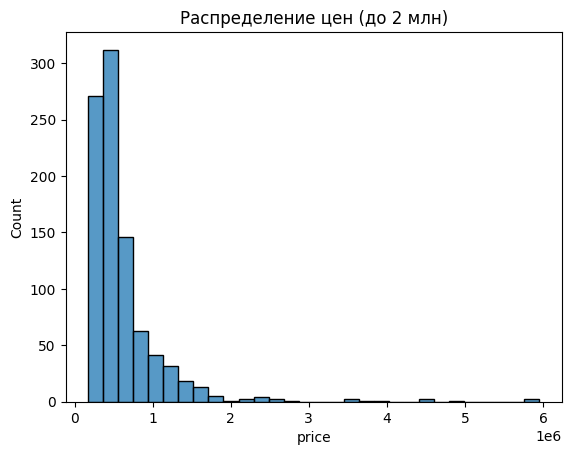

In [7]:
sns.histplot(df["price"], bins=30)
plt.title("Распределение цен (до 2 млн)")
plt.show()


## Удаление вылетов

In [8]:
df = df[df["price"] <= 2_000_000]


## Добавление признаков

In [9]:
df = add_price_per_sqm(df, price_col="price", area_col="area")
df = add_area_per_room(df, area_col="area", rooms_col="rooms")
df = add_geo_bins(df, lat_col="lat", lon_col="lon")
df = add_distance_to_center(df, lat_col="lat", lon_col="lon")
df = add_zip_prefix(df, zip_col="zip")


## Сохранение очищенных данных

In [10]:
df = df[["price", "area", "rooms", "price_per_sqm", "area_per_room", "lat_bin", "lon_bin", "distance_to_center_km", "zip_prefix"]]
save_cleaned_data(df)
df.head(2)


,price,area,rooms,price_per_sqm,area_per_room,lat_bin,lon_bin,distance_to_center_km,zip_prefix
0,685000.0,64.0,3.0,10703.125000,21.333333,52.36,4.91,1.297179,1091
1,475000.0,60.0,3.0,7916.666667,20.000000,52.35,4.85,4.221765,1059


## Корреляции

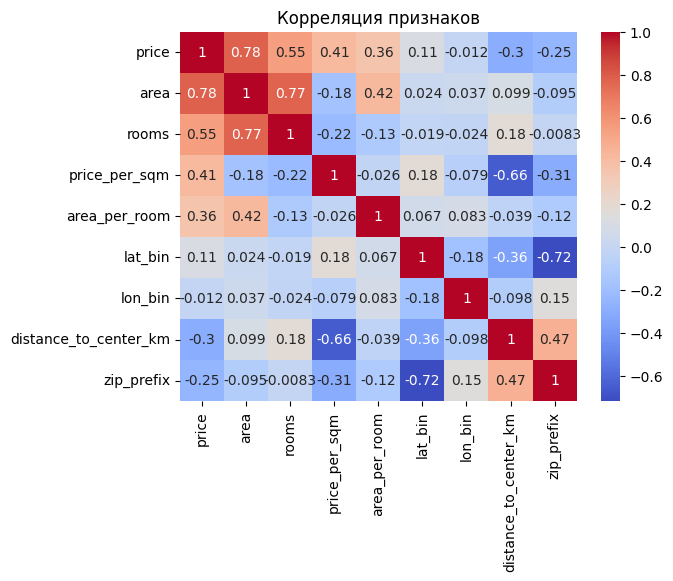

In [11]:
sns.heatmap(
    df.corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Корреляция признаков")
plt.show()


## Боксплот по районам

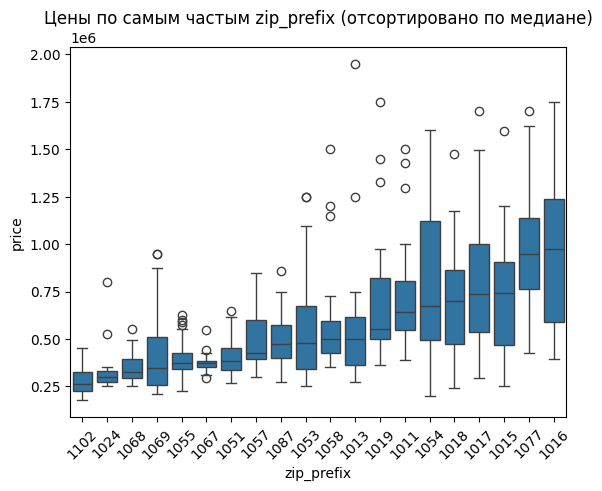

In [12]:
top_prefixes = df["zip_prefix"].value_counts().nlargest(20).index
df_top = df[df["zip_prefix"].isin(top_prefixes)]

ordered_prefixes = (
    df_top.groupby("zip_prefix")["price"]
    .median()
    .sort_values()
    .index
)

sns.boxplot(x="zip_prefix", y="price", data=df_top, order=ordered_prefixes)
plt.xticks(rotation=45)
plt.title("Цены по самым частым zip_prefix (отсортировано по медиане)")
plt.show()

## Таблица: средняя цена по районам

In [13]:
print(df_top.groupby("zip_prefix")["price"].mean().sort_values(ascending=False))


zip_prefix
1077    982000.000000
1016    961333.333333
1017    817461.538462
1054    805380.952381
1011    745375.000000
1015    734050.000000
1019    715304.347826
1018    694708.333333
1058    587880.000000
1013    575869.565217
1053    564807.692308
1087    516604.000000
1057    498217.391304
1069    435394.736842
1055    410310.344828
1051    408415.789474
1067    376666.666667
1068    348019.230769
1024    335200.000000
1102    276720.000000
Name: price, dtype: float64
